In [1]:
from scipy.stats import qmc
import pandas as pd
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import shutil
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import subprocess
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import ListedColormap
import contextily as ctx
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

### In this Notebook we make the all grass landcover inputs for heatsource scenario tsting:
- Find forested nodes by filtering shade values form a model run without topographic shade
- Make all nodes landcover grassy
- if nodes were previously forested, they are narrowed by %20 in the new grassy model 

In [2]:
#reading in data with relative paths so that it can be used by others who clone repository from github
#os.chdir(os.getcwd())
script_dir = os.getcwd()


base_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','july_baseline'))

#reading in a model run without topographic shading, for use in determining whether a reach is forested or not
notopo_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','july_notopo'))

#lc data scenario with buffer, to be used for adding grass to previously forested areas
buffer_source_folder = os.path.abspath(os.path.join(script_dir, 'scenarios','july_grassbuffer'))

#Temperature Observations folder
observed_temp_path = os.path.abspath(os.path.join(script_dir, 'observations', 'TemperatureDataObs'))
#Temperature observations
obs = pd.read_csv(os.path.join(observed_temp_path, 'HourlySummer23Master_riverkm.csv'))

In [40]:
#getting date times for modeled outputs
control_file = pd.read_csv(os.path.join(base_source_folder, 'HeatSource_Control.csv'))
cc_start = control_file.loc[7]['VALUE']
cc_start = pd.to_datetime(cc_start)
cc_end = control_file.loc[8]['VALUE']
cc_end = pd.to_datetime(cc_end)

#reading observed hourly temps for model range (for joining datetimes)
obs["datetime"] = pd.to_datetime(obs["datetime"])
obs_clip = obs[(obs["datetime"]>='07-01-2023') & (obs["datetime"]< '07-06-2023')]# + pd.DateOffset(1))]
#obs_clip = obs[(obs["datetime"]>=cc_start) & (obs["datetime"]<cc_end)]# + pd.DateOffset(1))]

# Make observed temps compatible with heatsource outputs
obs_clip = obs_clip.dropna(axis=1)
obs_clip = obs_clip.set_index('datetime')
#obs_clip.columns = [float(col) for col in obs_clip.columns[2:]]
obs_clip.columns = [float(col) for col in obs_clip.columns]
#obs_clip.drop(19.2, axis=1, inplace=True)
obs_clip_mean = obs_clip.resample('D').mean()

In [6]:
## Scenario Type: All Grass Baseline
landcover = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_lcdata.csv'))
morphology = pd.read_csv(os.path.join(base_source_folder, 'inputs\WFK23_morphology.csv'))
landcover_notopo = pd.read_csv(os.path.join(notopo_source_folder, 'inputs\WFK23_lcdata.csv'))
landcover_buffer = pd.read_csv(os.path.join(buffer_source_folder, 'inputs\WFK23_lcdata.csv'))
changed_nodes = {}

#making a new folder for allgrass scenario
original_folder_path = base_source_folder
new_folder_path = os.path.abspath(os.path.join(script_dir, 'scenarios', 'july_allgrass'))
shutil.copytree(original_folder_path, new_folder_path)

#adjust control file so it write output to correct folder
control_file = pd.read_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'))
control_file.loc[2, 'VALUE'] = str(os.path.join(new_folder_path, "inputs\\"))
control_file.loc[3, 'VALUE'] = str(os.path.join(new_folder_path, "outputs\\"))
control_file.to_csv(os.path.join(new_folder_path, 'HeatSource_Control.csv'), index = False)

landcover_km = landcover.copy()# Create a copy of landcover DataFrame
morphology_km = morphology.copy()# Create a copy of morphology DataFrame
reach_shade = notopo_shade_df#[(notopo_shade_df['NODE_ID'] <= km_start) & (notopo_shade_df['NODE_ID']>=km_end)]
##print(km_start)
    #changed_nodes[km_start] = []

#loop to remove shade at each node, narrows channel only where its currently grassy (where shade >.2 in baseline scenario)

for index, row in reach_shade.iterrows():
    #assigns bankbuffer shade to each node
    landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_buffer.loc[index, landcover_buffer.columns[8:48]]
    landcover_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_lcdata.csv'), index = False)

    # only widens currently grassy nodes
    if reach_shade.loc[index]['July Shade'] > .2:
        print('narrow @: ', index)


        #if you want to only increase shade at previouslt grassy nodes, uncomment the below line
        # landcover_km.loc[index, landcover_km.columns[8:48]] = landcover_bankbuffer.loc[index, landcover_km.columns[8:48]]
        print(morphology_km.loc[index,morphology_km.columns[5]])
        #narrow currently forested reaches by 20% when changed to grass
        morphology_km.loc[index,morphology_km.columns[5]] = morphology_km.loc[index,morphology_km.columns[5]]*.8
        print(morphology_km.loc[index,morphology_km.columns[5]])
        morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)            #morphology_km.to_csv(os.path.join(new_folder_path, 'inputs\WFK23_morphology.csv'), index = False)
            # changed_nodes[km_start].append(index)

os.chdir(new_folder_path)
subprocess.run(['hs', 'run', '-t'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

narrow @:  0
4.622692402
3.6981539216000003
narrow @:  1
8.533760609
6.8270084872000005
narrow @:  3
8.310317444
6.648253955200001
narrow @:  7
8.718198971
6.9745591768
narrow @:  10
8.449964817
6.7599718536
narrow @:  19
7.150098516
5.720078812800001
narrow @:  21
7.772499177
6.217999341600001
narrow @:  22
5.502179949
4.4017439592
narrow @:  23
8.959052177
7.167241741600001
narrow @:  24
8.836548496
7.069238796800001
narrow @:  26
9.23923197
7.391385576000001
narrow @:  27
6.523584603
5.2188676824
narrow @:  29
7.518262193
6.0146097544
narrow @:  30
14.85565711
11.884525688
narrow @:  31
14.97495111
11.979960888
narrow @:  32
19.68397505
15.747180040000002
narrow @:  33
14.57624632
11.660997056
narrow @:  34
16.58970978
13.271767824000001
narrow @:  35
11.90372491
9.522979928
narrow @:  38
8.437365089
6.749892071200001
narrow @:  42
10.57596997
8.460775975999999
narrow @:  43
11.63200131
9.305601048
narrow @:  49
6.822449525
5.4579596200000005
narrow @:  54
4.77995772
3.823966176
nar

CompletedProcess(args=['hs', 'run', '-t'], returncode=0)

In [41]:
base_tw_df = pd.read_csv(os.path.join(base_source_folder, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 187))
base_tw_df.columns = [float(col) for col in base_tw_df.columns]
base_tw_df.index = obs_clip.index
#mean july
mean_daily_base = base_tw_df.resample('D').mean()
mean_july_base = base_tw_df.mean()
mean_base = pd.DataFrame(mean_july_base)
mean_base = mean_base.reset_index()
mean_base.rename(columns={'index': 'NODE_ID', 0 : 'Mean'}, inplace=True)
mean_base['distance downstream'] = 18.3 - mean_base['NODE_ID']


allshade_tw_df = pd.read_csv(os.path.join(new_folder_path, 'outputs', 'Temp_H2O.csv'), skiprows=6,
         usecols=range(1, 187))
allshade_tw_df.columns = [float(col) for col in allshade_tw_df.columns]
allshade_tw_df.index = obs_clip.index
#mean july
mean_allshade = allshade_tw_df.resample('D').mean()
mean_allshade = allshade_tw_df.mean()
mean_allshade

mean_allshade = pd.DataFrame(mean_allshade)
mean_allshade = mean_allshade.reset_index()
mean_allshade.rename(columns={'index': 'NODE_ID', 0 : 'Mean'}, inplace=True)
mean_allshade['distance downstream'] = 18.3 - mean_allshade['NODE_ID']


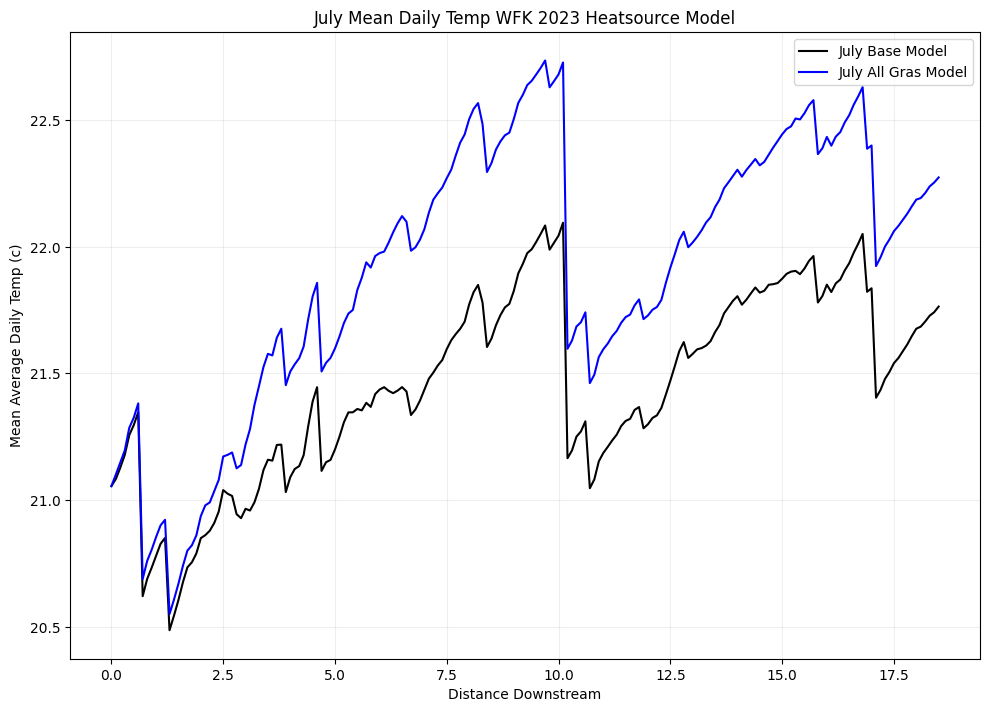

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(mean_base.index/10, mean_base['Mean'], label='July Base Model', color = 'black')
plt.plot(mean_allshade.index/10, mean_allshade['Mean'], label='July All Gras Model', color = 'blue')

#plt.plot(max_dailymean_scenario.index/10,max_dailymean_scenario['Max Daily Mean July Temp'],  label = 'Shade Scenario Model')


plt.ylabel('Mean Average Daily Temp (c)')
plt.xlabel('Distance Downstream')
#plt.figure(facecolor='black')

    # Adjust layout
plt.tight_layout()
plt.grid(alpha = .2)
#plt.ylim(21, 25)
#plt.vlines(trib_dict_downstream, ymin = 20, ymax = 25, label = 'Tribs',color = 'Orange', linestyles = 'dashed')
plt.legend()
plt.title('July Mean Daily Temp WFK 2023 Heatsource Model')
plt.savefig('JulyDailyMean_withobstribQ.png')
plt.show()
